In [7]:
# %pip install pandas
# %pip install matplotlib

In [8]:
# === Bootstrap cell: shared config, paths, JSON I/O, and GitHub REST/GraphQL helpers ===

import os, json, time, re, random, pathlib
from typing import Dict, Any, Optional, Tuple, List
from datetime import datetime, timezone

import requests
import yaml
from dotenv import load_dotenv

# -------------------------------------------------------------------
# Locate repo root reliably (works no matter where you open the .ipynb)
# -------------------------------------------------------------------
def _find_repo_root(start: pathlib.Path) -> pathlib.Path:
    cur = start.resolve()
    for _ in range(8):  # walk up to 8 levels
        if (cur / "config" / "config.yaml").exists():
            return cur
        cur = cur.parent
    raise FileNotFoundError("Couldn't locate repo root (no config/config.yaml found upward).")

REPO_ROOT = _find_repo_root(pathlib.Path.cwd())
CONFIG_PATH = REPO_ROOT / "config" / "config.yaml"

# -------------------------------------------------------------------
# Load config + token
# -------------------------------------------------------------------
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    CFG: Dict[str, Any] = yaml.safe_load(f) or {}

load_dotenv(REPO_ROOT / ".env")  # local only; do not commit .env
TOKEN_ENV = (CFG.get("github_token_env") or "GITHUB_TOKEN").strip()
GITHUB_TOKEN = os.getenv(TOKEN_ENV, "").strip()
if not GITHUB_TOKEN:
    raise RuntimeError(f"Missing token in environment variable {TOKEN_ENV}. "
                       f"Create .env from .env.example and set {TOKEN_ENV}=...")

# Repo + output root
REPO = CFG["repo"]  # "owner/name"
OWNER, NAME = REPO.split("/", 1)
OUT_ROOT = pathlib.Path(CFG.get("out_root") or NAME)  # "<name>" if null

# Behavior
OVERWRITE = bool(CFG.get("overwrite", True))
VERBOSE = bool(CFG.get("verbose_logs", True))

# Networking knobs
REQ_TIMEOUT = int(CFG.get("request_timeout_sec", 30))
MAX_RETRIES = int(CFG.get("max_retries", 4))
BACKOFF_BASE_MS = int(CFG.get("backoff_base_ms", 400))
BACKOFF_JITTER_MS = int(CFG.get("backoff_jitter_ms", 250))
RESPECT_RL = bool(CFG.get("respect_rate_limits", True))

# -------------------------------------------------------------------
# Tiny logging helpers
# -------------------------------------------------------------------
def log(msg: str) -> None:
    if VERBOSE:
        print(msg, flush=True)

def warn(msg: str) -> None:
    print(f"⚠️  {msg}", flush=True)

print("Using repo root:", REPO_ROOT)

# -------------------------------------------------------------------
# Canonical output layout helpers
# -------------------------------------------------------------------
def ensure_dir(p: pathlib.Path) -> None:
    p.mkdir(parents=True, exist_ok=True)

def repo_root() -> pathlib.Path:
    root = OUT_ROOT
    ensure_dir(root)
    return root

def tags_all_json() -> pathlib.Path:
    d = repo_root() / "tags"
    ensure_dir(d)
    return d / "tags.all.json"

def series_dir(kind: str, series: str) -> pathlib.Path:
    d = repo_root() / kind / series
    ensure_dir(d)
    return d

def pair_stem(base: str, compare: str) -> str:
    return f"{base}...{compare}"

def pair_json(series: str, stem: str, kind: str) -> pathlib.Path:
    # kind ∈ {"compare","commits","pulls","issues"}
    return series_dir(kind, series) / f"{stem}.{kind}.json"

def capsule_json(series: str, stem: str) -> pathlib.Path:
    return series_dir("commits_pr_issue", series) / f"{stem}.tarce_artifacts.json"

# -------------------------------------------------------------------
# JSON I/O
# -------------------------------------------------------------------
def read_json(path: pathlib.Path) -> Optional[Dict[str, Any]]:
    if not path.exists():
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def write_json(path: pathlib.Path, payload: Dict[str, Any]) -> None:
    ensure_dir(path.parent)
    if path.exists() and not OVERWRITE:
        log(f"Skip (exists): {path}")
        return
    tmp = path.with_suffix(path.suffix + ".tmp")
    with open(tmp, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)
    tmp.replace(path)
    log(f"✓ Wrote {path}")

# -------------------------------------------------------------------
# GitHub HTTP session + rate-limit aware helpers
# -------------------------------------------------------------------
SESSION = requests.Session()
SESSION.headers.update({
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "Accept": "application/vnd.github+json",
    "X-GitHub-Api-Version": "2022-11-28",
    "User-Agent": f"notebook-pipeline/{NAME}"
})

def _parse_reset_epoch(headers: Dict[str, Any]) -> Optional[int]:
    try:
        return int(headers.get("X-RateLimit-Reset") or headers.get("x-ratelimit-reset"))
    except Exception:
        return None

def _maybe_sleep_for_reset(resp: requests.Response) -> None:
    if not RESPECT_RL:
        return
    remaining = resp.headers.get("X-RateLimit-Remaining") or resp.headers.get("x-ratelimit-remaining")
    if remaining is not None and str(remaining).isdigit() and int(remaining) <= 0:
        reset_epoch = _parse_reset_epoch(resp.headers)
        if reset_epoch:
            now = int(time.time())
            delta = max(0, reset_epoch - now) + 1
            warn(f"Rate limit reached. Sleeping ~{delta}s until reset …")
            time.sleep(delta)

def _backoff_sleep(i: int) -> None:
    base = BACKOFF_BASE_MS / 1000.0
    jitter = random.uniform(0, BACKOFF_JITTER_MS / 1000.0)
    time.sleep((2 ** i) * base + jitter)

def rest_get_json(url: str, params: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    """
    Generic GET with backoff + rate-limit handling.
    """
    last_err = None
    for i in range(MAX_RETRIES + 1):
        try:
            r = SESSION.get(url, params=params, timeout=REQ_TIMEOUT)
            # Honor 429 Retry-After if present
            if r.status_code == 429:
                ra = r.headers.get("Retry-After")
                if ra and ra.isdigit():
                    wait_s = int(ra)
                    warn(f"429 received. Sleeping {wait_s}s per Retry-After …")
                    time.sleep(wait_s)
                    continue
            if r.status_code >= 500:
                last_err = f"{r.status_code} {r.text[:200]}"
                _backoff_sleep(i)
                continue
            if r.status_code >= 400:
                raise RuntimeError(f"HTTP {r.status_code}: {r.text[:500]}")
            _maybe_sleep_for_reset(r)
            return r.json()
        except Exception as e:
            last_err = str(e)
            _backoff_sleep(i)
    raise RuntimeError(f"GET failed after retries: {url} :: {last_err}")

def gh_graphql(query: str, variables: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    """
    GitHub GraphQL POST with backoff + rate-limit handling.
    Endpoint: https://api.github.com/graphql
    """
    url = "https://api.github.com/graphql"
    payload = {"query": query, "variables": variables or {}}
    last_err = None
    for i in range(MAX_RETRIES + 1):
        try:
            r = SESSION.post(url, json=payload, timeout=REQ_TIMEOUT)
            if r.status_code == 429:
                ra = r.headers.get("Retry-After")
                if ra and ra.isdigit():
                    wait_s = int(ra)
                    warn(f"429 received. Sleeping {wait_s}s per Retry-After …")
                    time.sleep(wait_s)
                    continue
            if r.status_code >= 500:
                last_err = f"{r.status_code} {r.text[:200]}"
                _backoff_sleep(i)
                continue
            if r.status_code >= 400:
                raise RuntimeError(f"GraphQL HTTP {r.status_code}: {r.text[:500]}")
            _maybe_sleep_for_reset(r)
            data = r.json()
            if "errors" in data:
                last_err = f"GraphQL errors: {data['errors']}"
                _backoff_sleep(i)
                continue
            return data
        except Exception as e:
            last_err = str(e)
            _backoff_sleep(i)
    raise RuntimeError(f"GraphQL failed after retries: {last_err}")

def rate_limit_snapshot() -> Dict[str, Any]:
    """
    Returns current REST rate-limit bucket (printed; not written to JSON outputs).
    """
    try:
        info = rest_get_json("https://api.github.com/rate_limit")
        core = info.get("resources", {}).get("core", {})
        remaining = core.get("remaining")
        limit = core.get("limit")
        reset = core.get("reset")
        when = datetime.fromtimestamp(reset, tz=timezone.utc).isoformat() if reset else None
        snap = {"limit": limit, "remaining": remaining, "reset_epoch": reset, "reset_iso": when}
        log(f"Rate limit: {remaining}/{limit}, resets at {when}")
        return snap
    except Exception as e:
        warn(f"Rate limit snapshot failed: {e}")
        return {}

# -------------------------------------------------------------------
# Light helpers for series + ordering
# -------------------------------------------------------------------
def semver_series(tag_name: str) -> str:
    """
    Extract 'vX.Y' series from tags like 'v4.2.3', '4.2.0-rc.1', etc.
    Falls back to 'v0.0' if not parseable.
    """
    m = re.search(r'v?(\d+)\.(\d+)', tag_name or "")
    if not m:
        return "v0.0"
    return f"v{int(m.group(1))}.{int(m.group(2))}"

def sorted_pairs_by_tag_time(pairs: List[Tuple[str, str]], tag_index: Dict[str, Dict[str, Any]]) -> List[Tuple[str, str]]:
    """
    Sort (base, compare) by tag timestamps ascending when both are tags;
    unknown timestamps sort last.
    """
    def ts(tag: str) -> float:
        rec = tag_index.get(tag)
        if rec and rec.get("tag_timestamp"):
            try:
                return datetime.fromisoformat(rec["tag_timestamp"].replace("Z", "+00:00")).timestamp()
            except Exception:
                pass
        return float("inf")
    return sorted(pairs, key=lambda bc: (ts(bc[0]), ts(bc[1])))

log("Bootstrap ready ✓")


Using repo root: /Users/rambodparsi/Desktop/OSS Repository Selection/web_scrapper/commit_pr_issue_analysis
Bootstrap ready ✓


Using: /Users/rambodparsi/Desktop/OSS Repository Selection/web_scrapper/commit_pr_issue_analysis/notebooks/mastodon/gemini_pred
Found series: ['v4.2']


,series,UI,Other,None,total_rows
0,v4.2,6,108,41,603


<Figure size 1000x600 with 0 Axes>

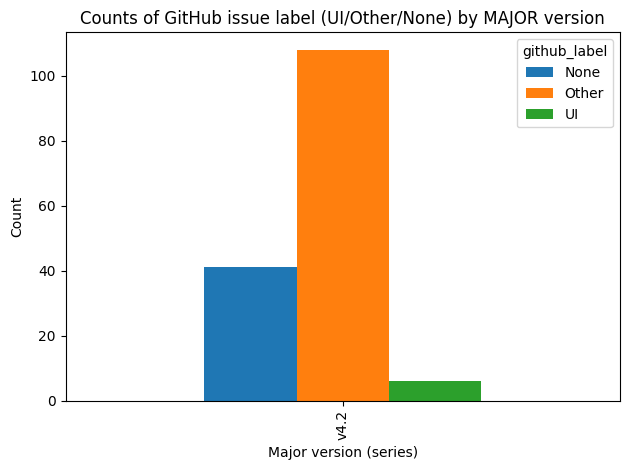

Saved:
- Table: /Users/rambodparsi/Desktop/OSS Repository Selection/web_scrapper/commit_pr_issue_analysis/notebooks/mastodon/deep_analysis/issue_analysis/issue_analysis_github_label_counts.csv
- Figure: /Users/rambodparsi/Desktop/OSS Repository Selection/web_scrapper/commit_pr_issue_analysis/notebooks/mastodon/deep_analysis/issue_analysis/issue_analysis_github_label_counts.png


In [14]:
# m9_analysis — issue_analysis (part 1, bootstrap-free, saves under <name>/deep_analysis/issue_analysis)
# Compares major versions by counts of `github_label` (UI/Other/None only) using <name>/gemini_pred/v*.csv
# Writes outputs to: <name>/deep_analysis/issue_analysis/

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---- Configuration (optional): set NAME explicitly if you know it
NAME = None  # e.g., "mastodon"

ROOT = Path(".").resolve()

def autodetect_name(root: Path):
    """
    Find a subfolder under root that has gemini_pred/v*.csv files.
    If multiple candidates, pick the one with the most v*.csv files.
    """
    candidates = []
    for d in root.iterdir():
        if not d.is_dir():
            continue
        gp = d / "gemini_pred"
        if gp.exists():
            csvs = list(gp.glob("v*.csv"))
            if csvs:
                candidates.append((d.name, len(csvs)))
    if not candidates:
        return None
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0]

# Decide NAME
if not NAME:
    NAME = autodetect_name(ROOT)

if not NAME:
    raise FileNotFoundError(
        "Could not find any <name>/gemini_pred/v*.csv under the current repo. "
        "Set NAME to your project folder (e.g. NAME='mastodon') and re-run."
    )

pred_dir = ROOT / NAME / "gemini_pred"
if not pred_dir.exists():
    raise FileNotFoundError(f"gemini_pred folder not found at: {pred_dir}")

csv_paths = sorted(pred_dir.glob("v*.csv"))
if not csv_paths:
    raise FileNotFoundError(f"No v*.csv files found under {pred_dir}.")

print(f"Using: {pred_dir}")
print("Found series:", [p.stem for p in csv_paths])

# --- Build per-version summary (exclude 'No Issue' from counts/plot) ---
records = []
for p in csv_paths:
    series = p.stem  # e.g., "v4.2"
    df = pd.read_csv(p)

    # If github_label is missing, derive a safe default from issue text
    if "github_label" not in df.columns:
        def _derive(row):
            t = str(row.get("issue_title","")).strip()
            b = str(row.get("issue_body","")).strip()
            return "No Issue" if (not t and not b) else "None"
        df["github_label"] = df.apply(_derive, axis=1)

    # Count only UI / Other / None
    counts = df["github_label"].fillna("None").value_counts(dropna=False).to_dict()
    row = {"series": series}
    for k in ["UI", "Other", "None"]:  # ← 'No Issue' removed here
        row[k] = int(counts.get(k, 0))

    # Keep total rows for context (unchanged)
    row["total_rows"] = int(len(df))
    records.append(row)

summary = pd.DataFrame(records).sort_values("series")

# --- Ensure output dir under <name> ---
out_dir = ROOT / NAME / "deep_analysis" / "issue_analysis"
out_dir.mkdir(parents=True, exist_ok=True)

# --- Save and show table ---
out_csv = out_dir / "issue_analysis_github_label_counts.csv"
summary.to_csv(out_csv, index=False)

try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("github_label counts per series (UI/Other/None only)", summary)
except Exception:
    display(summary)

# --- Plot grouped bar chart (UI/Other/None only) ---
long_df = summary.melt(
    id_vars=["series","total_rows"],
    value_vars=["UI","Other","None"],   # ← 'No Issue' removed here
    var_name="github_label",
    value_name="count"
)
pivot = long_df.pivot(index="series", columns="github_label", values="count").fillna(0)

plt.figure(figsize=(10, 6))
pivot.plot(kind="bar")
plt.title("Counts of GitHub issue label (UI/Other/None) by MAJOR version")
plt.xlabel("Major version (series)")
plt.ylabel("Count")
plt.tight_layout()

out_png = out_dir / "issue_analysis_github_label_counts.png"
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()

print(f"Saved:\n- Table: {out_csv}\n- Figure: {out_png}")


Using input dir: /Users/rambodparsi/Desktop/OSS Repository Selection/web_scrapper/commit_pr_issue_analysis/notebooks/mastodon/gemini_pred
Found series: ['v4.2']
Saved table → /Users/rambodparsi/Desktop/OSS Repository Selection/web_scrapper/commit_pr_issue_analysis/notebooks/mastodon/deep_analysis/issue_analysis/issue_analysis_label_source_compare.csv


<Figure size 1200x600 with 0 Axes>

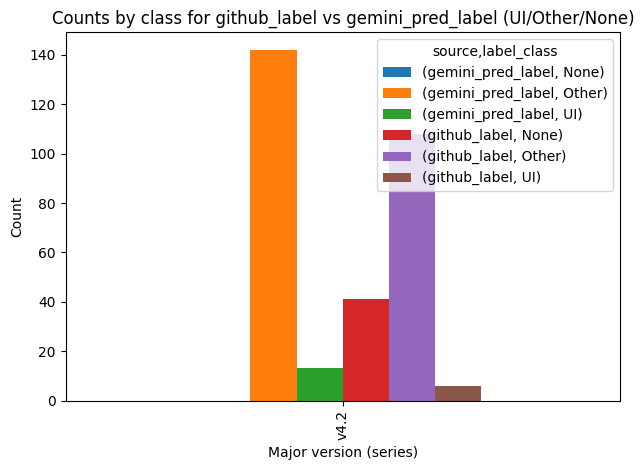

Saved figure → /Users/rambodparsi/Desktop/OSS Repository Selection/web_scrapper/commit_pr_issue_analysis/notebooks/mastodon/deep_analysis/issue_analysis/issue_analysis_label_source_compare.png


In [10]:
# m9_analysis — issue_analysis (part 2, bootstrap-free, UI/Other/None, excludes "No Issue")
# Inputs:  <name>/gemini_pred/v*.csv
# Outputs: <name>/deep_analysis/issue_analysis/issue_analysis_label_source_compare.(csv|png)

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import json, re

# --- Optional: set project folder explicitly (e.g., "mastodon"), else auto-detect ---
NAME = None
ROOT = Path(".").resolve()

def autodetect_name(root: Path):
    best = (None, -1)
    for d in root.iterdir():
        if not d.is_dir():
            continue
        gp = d / "gemini_pred"
        if not gp.exists():
            continue
        n = len(list(gp.glob("v*.csv")))
        if n > best[1]:
            best = (d.name, n)
    return best[0] if best[1] > 0 else None

if not NAME:
    NAME = autodetect_name(ROOT)
if not NAME:
    raise FileNotFoundError(
        "Could not find any <name>/gemini_pred/v*.csv under the repo root.\n"
        "Set NAME='your_project' near the top of this cell and run again."
    )

pred_dir = ROOT / NAME / "gemini_pred"
csv_paths = sorted(pred_dir.glob("v*.csv"))
if not csv_paths:
    raise FileNotFoundError(f"No v*.csv files found under {pred_dir}.")

print(f"Using input dir: {pred_dir}")
print("Found series:", [p.stem for p in csv_paths])

# --- helpers (only used if we need to re-derive gemini_pred_label from gemini_label text) ---
CODE_FENCE_RE = re.compile(r"```(?:json|JSON)?\s*(.*?)\s*```", re.DOTALL)
FIRST_OBJECT_RE = re.compile(r"\{.*?\}", re.DOTALL)
CLASS_PAIR_RE  = re.compile(r'"class"\s*:\s*"([^"]+)"')

def extract_json_class(raw: str) -> str:
    """Return JSON['class'] from gemini_label (supports ```json ... ``` fences & noisy text)."""
    if raw is None:
        return ""
    s = str(raw).strip()
    m = CODE_FENCE_RE.search(s)
    if m:
        s = m.group(1).strip()
    try:
        obj = json.loads(s)
        if isinstance(obj, dict) and "class" in obj:
            val = obj.get("class")
            return "" if val is None else str(val)
    except Exception:
        pass
    m = FIRST_OBJECT_RE.search(s)
    if m:
        candidate = m.group(0)
        try:
            obj = json.loads(candidate)
            if isinstance(obj, dict) and "class" in obj:
                val = obj.get("class")
                return "" if val is None else str(val)
        except Exception:
            pass
    m = CLASS_PAIR_RE.search(s)
    if m:
        return m.group(1)
    return ""

# --- build per-version comparison (UI/Other/None), exclude "No Issue" rows ---
rows = []
for p in csv_paths:
    series = p.stem
    df = pd.read_csv(p)

    # Vectorized, NaN-safe "has issue" flag
    it = df["issue_title"] if "issue_title" in df.columns else pd.Series([""]*len(df))
    ib = df["issue_body"]  if "issue_body"  in df.columns else pd.Series([""]*len(df))
    has_issue = (it.fillna("").astype(str).str.strip().ne("")) | (ib.fillna("").astype(str).str.strip().ne(""))
    df["_has_issue"] = has_issue

    # github_label fallback (if missing)
    if "github_label" not in df.columns:
        df["github_label"] = df["_has_issue"].map(lambda x: "None" if x else "No Issue")

    # gemini_pred_label fallback (if missing)
    if "gemini_pred_label" not in df.columns:
        if "gemini_label" in df.columns:
            df["gemini_pred_label"] = df["gemini_label"].map(extract_json_class)
        else:
            df["gemini_pred_label"] = ""

    # treat empty gemini_pred_label as "None" for counting
    mask_empty = df["gemini_pred_label"].isna() | (df["gemini_pred_label"].astype(str).str.strip() == "")
    df.loc[mask_empty, "gemini_pred_label"] = "None"

    # keep only rows with an issue (exclude "No Issue")
    dfi = df[df["_has_issue"]].copy()

    # Count per class for both sources
    classes = ["UI", "Other", "None"]
    gh_counts = dfi["github_label"].fillna("None").value_counts().to_dict()
    gm_counts = dfi["gemini_pred_label"].fillna("None").value_counts().to_dict()

    for cls in classes:
        rows.append({"series": series, "source": "github_label",      "label_class": cls, "count": int(gh_counts.get(cls, 0))})
        rows.append({"series": series, "source": "gemini_pred_label", "label_class": cls, "count": int(gm_counts.get(cls, 0))})

cmp_df = pd.DataFrame(rows).sort_values(["series", "source", "label_class"])

# --- save table and plot under <name>/deep_analysis/issue_analysis ---
out_dir = ROOT / NAME / "deep_analysis" / "issue_analysis"
out_dir.mkdir(parents=True, exist_ok=True)
out_csv = out_dir / "issue_analysis_label_source_compare.csv"
cmp_df.to_csv(out_csv, index=False)
print("Saved table →", out_csv)

# pivot to columns=(source,label_class) so both sources show per series
pivot = cmp_df.pivot_table(index="series", columns=["source", "label_class"], values="count", fill_value=0, aggfunc="sum")

plt.figure(figsize=(12, 6))
pivot.plot(kind="bar")           # one plot, no custom colors/styles
plt.title("Counts by class for github_label vs gemini_pred_label (UI/Other/None)")
plt.xlabel("Major version (series)")
plt.ylabel("Count")
plt.tight_layout()

out_png = out_dir / "issue_analysis_label_source_compare.png"
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()
print("Saved figure →", out_png)


In [11]:
# m9_analysis — issue_analysis (metrics)
# Accuracy / Precision / Recall / F1 per major version
# Inputs:  <name>/gemini_pred/v*.csv
# Output:  <name>/deep_analysis/issue_analysis/issue_metrics_per_version.csv

from pathlib import Path
import pandas as pd
import json, re

# ---- set explicitly if auto-detect fails ----
NAME = None  # e.g., "mastodon"
ROOT = Path(".").resolve()

def autodetect_name(root: Path):
    best = (None, -1)
    for d in root.iterdir():
        if not d.is_dir():
            continue
        gp = d / "gemini_pred"
        if not gp.exists():
            continue
        n = len(list(gp.glob("v*.csv")))
        if n > best[1]:
            best = (d.name, n)
    return best[0] if best[1] > 0 else None

if not NAME:
    NAME = autodetect_name(ROOT)
if not NAME:
    raise FileNotFoundError("Could not find any <name>/gemini_pred/v*.csv under repo root. "
                            "Set NAME='your_project' above and re-run.")

pred_dir = ROOT / NAME / "gemini_pred"
csv_paths = sorted(pred_dir.glob("v*.csv"))
if not csv_paths:
    raise FileNotFoundError(f"No v*.csv files found under {pred_dir}.")

# --- helpers to derive gemini_pred_label from gemini_label if needed ---
CODE_FENCE_RE = re.compile(r"```(?:json|JSON)?\s*(.*?)\s*```", re.DOTALL)
FIRST_OBJECT_RE = re.compile(r"\{.*?\}", re.DOTALL)
CLASS_PAIR_RE  = re.compile(r'"class"\s*:\s*"([^"]+)"')

def extract_json_class(raw: str) -> str:
    if raw is None:
        return ""
    s = str(raw).strip()
    m = CODE_FENCE_RE.search(s)
    if m:
        s = m.group(1).strip()
    # try full JSON
    try:
        obj = json.loads(s)
        if isinstance(obj, dict) and "class" in obj:
            val = obj.get("class")
            return "" if val is None else str(val)
    except Exception:
        pass
    # try first {...}
    m = FIRST_OBJECT_RE.search(s)
    if m:
        candidate = m.group(0)
        try:
            obj = json.loads(candidate)
            if isinstance(obj, dict) and "class" in obj:
                val = obj.get("class")
                return "" if val is None else str(val)
        except Exception:
            pass
    # last-resort regex
    m = CLASS_PAIR_RE.search(s)
    return m.group(1) if m else ""

def binarize_pred(label: str) -> str:
    # Positive = "UI"; all other values collapse to "Other"
    return "UI" if str(label).strip() == "UI" else "Other"

def safe_div(n, d):
    return float(n) / float(d) if d else float("nan")

rows_out = []
for p in csv_paths:
    series = p.stem
    df = pd.read_csv(p)

    # Vectorized, NaN-safe "has issue" flag
    it = df["issue_title"] if "issue_title" in df.columns else pd.Series([""]*len(df))
    ib = df["issue_body"]  if "issue_body"  in df.columns else pd.Series([""]*len(df))
    has_issue = (it.fillna("").astype(str).str.strip().ne("")) | (ib.fillna("").astype(str).str.strip().ne(""))
    df["_has_issue"] = has_issue

    # Ensure github_label
    if "github_label" not in df.columns:
        df["github_label"] = df["_has_issue"].map(lambda x: "None" if x else "No Issue")

    # Ensure gemini_pred_label (derive from gemini_label if missing)
    if "gemini_pred_label" not in df.columns:
        if "gemini_label" in df.columns:
            df["gemini_pred_label"] = df["gemini_label"].map(extract_json_class)
        else:
            df["gemini_pred_label"] = ""

    # Keep only rows: has issue & ground truth in {UI, Other}
    dfg = df[(df["_has_issue"]) & (df["github_label"].isin(["UI", "Other"]))].copy()

    if dfg.empty:
        rows_out.append({
            "series": series,
            "n_samples": 0,
            "tp": 0, "fp": 0, "tn": 0, "fn": 0,
            "accuracy": float("nan"),
            "precision_UI": float("nan"),
            "recall_UI": float("nan"),
            "f1_UI": float("nan"),
        })
        continue

    # Build binary vectors: y_true ∈ {UI, Other}; y_pred := UI if exactly "UI" else Other
    dfg["y_true"] = dfg["github_label"].astype(str).str.strip().map(lambda s: "UI" if s == "UI" else "Other")
    dfg["y_pred"] = dfg["gemini_pred_label"].astype(str).map(binarize_pred)

    tp = int(((dfg["y_true"] == "UI")    & (dfg["y_pred"] == "UI")).sum())
    fp = int(((dfg["y_true"] == "Other") & (dfg["y_pred"] == "UI")).sum())
    fn = int(((dfg["y_true"] == "UI")    & (dfg["y_pred"] != "UI")).sum())
    tn = int(((dfg["y_true"] == "Other") & (dfg["y_pred"] != "UI")).sum())

    n = tp + fp + fn + tn
    acc  = safe_div(tp + tn, n)
    prec = safe_div(tp, tp + fp)
    rec  = safe_div(tp, tp + fn)
    f1   = safe_div(2 * prec * rec, (prec + rec)) if (prec == prec and rec == rec and (prec + rec)) else float("nan")

    rows_out.append({
        "series": series,
        "n_samples": n,
        "tp": tp, "fp": fp, "tn": tn, "fn": fn,
        "accuracy": acc,
        "precision_UI": prec,
        "recall_UI": rec,
        "f1_UI": f1,
    })

metrics_df = pd.DataFrame(rows_out).sort_values("series")

out_dir = ROOT / NAME / "deep_analysis" / "issue_analysis"
out_dir.mkdir(parents=True, exist_ok=True)
out_csv = out_dir / "issue_metrics_per_version.csv"
metrics_df.to_csv(out_csv, index=False)

# show table inline when supported
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Per-version accuracy / precision / recall / F1 (UI as positive)", metrics_df)
except Exception:
    print(metrics_df)

print(f"Saved metrics table → {out_csv}")


  series  n_samples  tp  fp   tn  fn  accuracy  precision_UI  recall_UI  f1_UI
0   v4.2        114   2   8  100   4  0.894737           0.2   0.333333   0.25
Saved metrics table → /Users/rambodparsi/Desktop/OSS Repository Selection/web_scrapper/commit_pr_issue_analysis/notebooks/mastodon/deep_analysis/issue_analysis/issue_metrics_per_version.csv


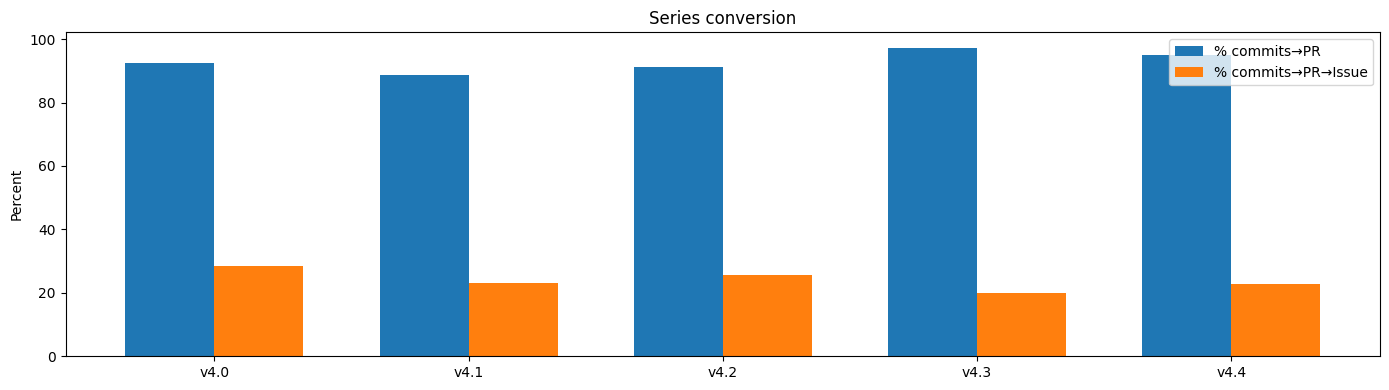

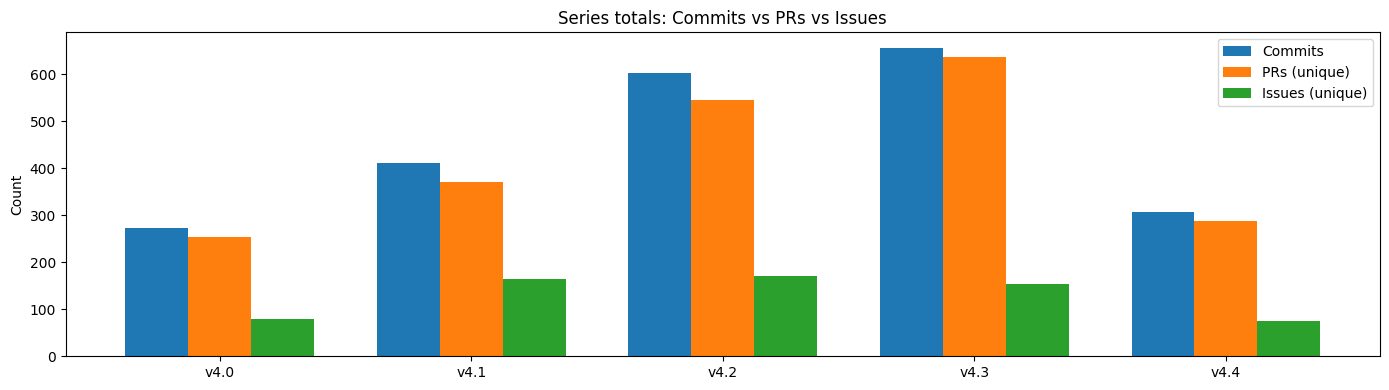

Saved in: /Users/rambodparsi/Desktop/OSS Repository Selection/web_scrapper/commit_pr_issue_analysis/notebooks/mastodon/deep_analysis/major_versions_analysis


In [12]:
# m9_analysis — recreate the two "deep analysis" plots across major versions
# Inputs:  <name>/commits_pr_issue/<series>/*.json   (from M6)
# Outputs: <name>/deep_analysis/major_versions_analysis/
#          - conversion.summary.csv / conversion.grouped.png
#          - counts.summary.csv     / counts.grouped.png

from pathlib import Path
import json, re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- EDIT if your project folder name differs
NAME = "mastodon"   # e.g., "mastodon", "myrepo", ...

ROOT = Path(".").resolve()
cpi_dir = ROOT / NAME / "commits_pr_issue"
if not cpi_dir.exists():
    raise FileNotFoundError(f"Expected folder not found: {cpi_dir}\n"
                            "Make sure your M6 outputs live under <name>/commits_pr_issue/.")

series_dirs = sorted([p for p in cpi_dir.glob("v*") if p.is_dir()])

def series_key(s: str):
    m = re.match(r"v?(\d+)\.(\d+)", s)
    if m:
        return (int(m.group(1)), int(m.group(2)))
    return (9999, 9999)

summary_rows = []
conv_rows = []

for sdir in sorted(series_dirs, key=lambda p: series_key(p.name)):
    series = sdir.name
    json_paths = sorted(sdir.glob("*.json"))
    if not json_paths:
        continue

    total_commits = 0
    commits_with_pr = 0
    commits_with_pr_issue = 0

    pr_ids = set()
    issue_ids = set()

    for jp in json_paths:
        try:
            data = json.loads(jp.read_text(encoding="utf-8"))
        except Exception as e:
            print(f"⚠️  Skip unreadable {jp.name}: {e}")
            continue

        capsules = data.get("commit_pr_issue", [])
        if not isinstance(capsules, list):
            continue

        total_commits += len(capsules)

        for cap in capsules:
            prs = cap.get("prs", []) or []
            issues = cap.get("issues", []) or []

            # conversion tallies
            if prs:
                commits_with_pr += 1
                if issues:
                    commits_with_pr_issue += 1

            # unique PR ids
            for pr in prs:
                ident = pr.get("number")
                if ident is None:
                    ident = pr.get("api_url") or pr.get("html_url")
                if ident:
                    pr_ids.add(str(ident))

            # unique Issue ids
            for iss in issues:
                ident = iss.get("number")
                if ident is None:
                    ident = iss.get("html_url")
                if ident:
                    issue_ids.add(str(ident))

    pct_commit_pr        = (commits_with_pr / total_commits * 100.0) if total_commits else 0.0
    pct_commit_pr_issue  = (commits_with_pr_issue / total_commits * 100.0) if total_commits else 0.0

    summary_rows.append({
        "series": series,
        "commits": total_commits,
        "prs_unique": len(pr_ids),
        "issues_unique": len(issue_ids),
    })
    conv_rows.append({
        "series": series,
        "pct_commits_to_pr": round(pct_commit_pr, 2),
        "pct_commits_to_pr_issue": round(pct_commit_pr_issue, 2),
    })

counts_df = pd.DataFrame(summary_rows).sort_values("series", key=lambda col: col.map(series_key))
conv_df   = pd.DataFrame(conv_rows).sort_values("series", key=lambda col: col.map(series_key))

out_dir = ROOT / NAME / "deep_analysis" / "major_versions_analysis"
out_dir.mkdir(parents=True, exist_ok=True)

# Save CSVs
counts_df.to_csv(out_dir / "counts.summary.csv", index=False)
conv_df.to_csv(out_dir / "conversion.summary.csv", index=False)

# --- Plot 1: conversion grouped bars (no custom colors/styles) ---
x = conv_df["series"].tolist()
y1 = conv_df["pct_commits_to_pr"].tolist()
y2 = conv_df["pct_commits_to_pr_issue"].tolist()

idx = np.arange(len(x)); width = 0.35
fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(idx - width/2, y1, width, label="% commits→PR")
ax.bar(idx + width/2, y2, width, label="% commits→PR→Issue")
ax.set_title("Series conversion")
ax.set_ylabel("Percent")
ax.set_xticks(idx); ax.set_xticklabels(x)
ax.legend(); fig.tight_layout()
plt.savefig(out_dir / "conversion.grouped.png", dpi=150, bbox_inches="tight")
plt.show()

# --- Plot 2: counts grouped bars (no custom colors/styles) ---
x = counts_df["series"].tolist()
c = counts_df["commits"].tolist()
p = counts_df["prs_unique"].tolist()
i = counts_df["issues_unique"].tolist()

idx = np.arange(len(x)); width = 0.25
fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.bar(idx - width, c, width, label="Commits")
ax2.bar(idx,         p, width, label="PRs (unique)")
ax2.bar(idx + width, i, width, label="Issues (unique)")
ax2.set_title("Series totals: Commits vs PRs vs Issues")
ax2.set_ylabel("Count")
ax2.set_xticks(idx); ax2.set_xticklabels(x)
ax2.legend(); fig2.tight_layout()
plt.savefig(out_dir / "counts.grouped.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved in:", out_dir)
